# dispersion workflow

### outline
- query MP
- define 'sim2l' inputs
- run through relax_sim, step by step
- get dispersion data

## get structure

In [1]:
#data tools
import pandas as pd
import numpy as np
import qgrid
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
import logging

#simtool loading and interface
from simtool import findInstalledSimToolNotebooks,searchForSimTool
from simtool import getSimToolInputs,getSimToolOutputs,Run

#user interface utilities 
import os, stat
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from IPython.display import HTML

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# load in some POSCAR file, as MP is currently down/
#users can pass their own structure as a poscar. the simtool will take the file contents as a dictionary which is produced here
struct = Structure.from_file("./POSCAR")
struct_dict = struct.as_dict()
struct_dict

{'@module': 'pymatgen.core.structure',
 '@class': 'Structure',
 'charge': None,
 'lattice': {'matrix': [[3.301912, 0.0, 1.90636],
   [1.100637, 3.113073, 1.90636],
   [0.0, 0.0, 3.81272]],
  'a': 3.8127196730606885,
  'b': 3.812719994793481,
  'c': 3.81272,
  'alpha': 59.99999995482746,
  'beta': 59.99999716342495,
  'gamma': 60.00000590953,
  'volume': 39.19130382736453},
 'sites': [{'species': [{'element': 'S', 'occu': 1}],
   'abc': [0.25, 0.25, 0.25],
   'xyz': [1.1006372500000001, 0.77826825, 1.90636],
   'label': 'S',
   'properties': {}},
  {'species': [{'element': 'Zn', 'occu': 1}],
   'abc': [0.0, 0.0, 0.0],
   'xyz': [0.0, 0.0, 0.0],
   'label': 'Zn',
   'properties': {}}]}

## define inputs

In [9]:
loglevel = "DEBUG"
numnodes = 1
walltime = "01:00:00"
pps = ['Zn.pbe.upf','S.pbe.upf']
smearing  = 'fixed'
ecutwfc = 50
ecutrho = 200
kpoints = 1
epsil = True
lraman = True
struct_dict = struct_dict

In [10]:
vars()["DEBUG"] = logging.DEBUG
vars()["INFO"] = logging.INFO
vars()["WARNING"] = logging.WARNING
vars()["ERROR"] = logging.ERROR
vars()["CRITICAL"] = logging.CRITICAL
logfmt = '[%(levelname)s] %(asctime)s - %(message)s'
logging.basicConfig(filename='run.log', level=vars()[loglevel], datefmt="%Y-%m-%d %H:%M:%S", format=logfmt)

## run simtool, step by step

In [11]:
#cli utilities
import io
import shutil
import subprocess

#nanohub utilities
import hublib.use
import fileinput
from simtool import DB, parse

#automate retreival of crystal structures and pseudopotentials from Materials Project
from pymatgen.core import Structure, Lattice, Element, Composition
import openbabel # automates translation of pymatgen structs to useful file formats
#process and categorize crystal structures

#misc tools
import math
import pandas as pd
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.16f}'.format}, suppress=False)

#%use espresso-6.2.1
#Apparently not functioning? sufficient to declare espresso-6.8 in submit call

In [12]:
# convert poscar back to structure object
#TODO we want to test resulting periodicsites objects for significant digits. log and WARN user of insufficient precisions + advise to set nosym parameter to TRUE in that case.
struct = Structure.from_dict(struct_dict)
logging.debug(f"the struct is made! {struct.sites}")

In [13]:
#get compound from poscar
compound = struct.formula

logging.info(f"User Entered: {compound}")
vcomp = Composition.ranked_compositions_from_indeterminate_formula(compound, lock_if_strict=True)
logging.info(f"User likely refering to one of these compositions: {vcomp}")
if isinstance(vcomp, list) and vcomp:
    vcomp = vcomp[0] #ordered by likelyhood so pick best candidate
    logging.debug(f"vcomp is type {type(vcomp)}")
    if not vcomp.valid:
        logging.info(f"the input composition contains dummy species")
else:
    raise ValueError(f"The compound: {compound} is not recognizable as a valid chemical formula")

In [14]:
# extract element key from pps
pppart_list = []
for pp in pps:
    ppparts = pp.split('.')
    pppart_list.append(ppparts[0])
    logging.debug(f"from {pp} got {ppparts[0]}")
#sort formula elements and atomic mass by decending atomic mass
amass_ar = np.array([Element(el).atomic_mass for el in vcomp.to_reduced_dict.keys()])
massive_first = np.argsort(amass_ar).tolist()[::-1]
amass_falling = amass_ar[massive_first]
el_falling = np.array([el for el in vcomp.to_reduced_dict.keys()])[massive_first]
logging.debug(f"Elements in order of decending mass: {el_falling}. Decending mass: {amass_falling}")
#sort pps to match
pps_amass_ar = np.array([Element(el).atomic_mass for el in pppart_list])
pps_massive_first = np.argsort(pps_amass_ar).tolist()[::-1]
pps_falling = np.array(pps)[pps_massive_first]
logging.debug(f"Pseudopotentials in order of decending mass: {pps_falling}")

if len(pps_falling) != len(el_falling):
    logging.warning(f"There are not as many Pseudopotentials as Species. This may not work")

In [15]:
#Create cell parameters block
bio = io.BytesIO()
np.savetxt(bio, struct.lattice.matrix*1.88973, fmt="%0.8f")# to much precision in the input files causes convergence issues. to little causes symmetry issues.
cell_parameters_block = bio.getvalue().decode('latin1')
logging.info(f"""The standardized conventional lattice parameters are obtained:
            {cell_parameters_block}""")

In [16]:
#pw's atomic Species block and dm's amass_block
atomic_species_block = """"""
for pp, amass, species in zip(pps_falling, amass_falling, el_falling):
    block_line = f"{species} {amass} {pp}\n"
    atomic_species_block += block_line
logging.info(f"""The atomic_species_block:
{atomic_species_block}""")

amass_block = """"""
for ind, amass in enumerate(amass_falling):
    block_line = f"amass({ind+1})={amass},\n  "
    amass_block += block_line
ntyp_num = ind # this gives the wrong answer?
ntyp_num = len(np.unique([''.join([i for i in str(i.species) if i.isalpha()]) for i in struct.sites]))
logging.debug(f"ntyp = {ntyp_num}")
logging.info(f"""The amass_block:
{amass_block}""")

In [17]:
def get_fractional_coords_as_qe_array(periodicsitesobj):
    at_site = np.array([str(*periodicsitesobj.species.to_reduced_dict.keys()), periodicsitesobj.a, periodicsitesobj.b, periodicsitesobj.c])
    logging.debug(f"atomic sites array: {at_site}")
    # str might break if the species has whitespaces in it... I think. Or maybe that's just for unpacked lists
    return at_site

nat_num = len(struct.sites)
atomic_positions_block = np.array(list(map(lambda x: get_fractional_coords_as_qe_array(x), struct.sites)))
bio = io.BytesIO()
np.savetxt(bio, atomic_positions_block, fmt="%s", encoding="latin1")
atomic_positions_block = bio.getvalue().decode('latin1')
logging.info(f"""The atomic sites are obtained:
            {atomic_positions_block}""")

In [18]:
# generate a k-point grid from the provided kpoint magnitude and lattice vectors
b = np.array([1/a for a in struct.lattice.abc])
b = b*(1/max(b))
k = np.ceil(kpoints*b)
kpoints_block = f"""{k[0]} {k[1]} {k[2]} 0 0 0"""

#choose the number of relaxation steps
n_estep = 1000

In [19]:
vcrelax_input = f"""
 &control
    calculation='vc-relax',
    restart_mode='from_scratch',
    prefix='{vcomp.reduced_formula}',
    outdir='./',
    pseudo_dir = './',
    etot_conv_thr=1.0d-6,
    forc_conv_thr=1.0d-6,
/
 &system    
    ibrav= 0, celldm(1)=1 ,nat= {nat_num}, ntyp= {ntyp_num},
    ecutwfc = {ecutwfc}, ecutrho = {ecutrho},
    occupations={smearing}, {"smearing='mp', degauss=0.06," if smearing == 'smearing' else ""}
/
 &electrons
    mixing_beta =0.7,
    conv_thr =1.0d-6,
    electron_maxstep = {n_estep}
/
 &ions
    ion_dynamics='bfgs'
/
&cell
    cell_dynamics='bfgs',
    press=0.0,
    cell_factor=2.0,
    press_conv_thr=0.5,
/
CELL_PARAMETERS (alat= 1.00000000)
{cell_parameters_block}
ATOMIC_SPECIES
{atomic_species_block}
ATOMIC_POSITIONS (crystal)
{atomic_positions_block}
K_POINTS (automatic)
{kpoints_block}
"""

ph_input = f"""
Normal modes for {vcomp.reduced_formula}
 &inputph
  tr2_ph=1.0d-14,
  prefix='{vcomp.reduced_formula}',
  {amass_block}outdir='./'
  epsil=.{epsil}.,
  lraman=.{lraman}.,
  trans=.true.,
  asr=.true.,
  fildyn='dmat.{vcomp.reduced_formula}'
  ! ldisp=.true.
 /
 0.0 0.0 0.0
"""

dm_input = f"""
&input fildyn='dmat.{vcomp.reduced_formula}', asr='zero-dim' /
"""
logging.debug(f"{ph_input}")

In [20]:
# fixed starting point input file generation
vcr_input_file = open(f"{vcomp.reduced_formula}.vc-relax.in", "w")
ph_input_file = open(f"{vcomp.reduced_formula}.ph.in", "w")
dm_input_file = open(f"{vcomp.reduced_formula}.dm.in", "w")

vcr_input_file.write(vcrelax_input)
ph_input_file.write(ph_input)
dm_input_file.write(dm_input)

vcr_input_file.close()
ph_input_file.close()
dm_input_file.close()

In [21]:
# output file generation
vcr_output_file = open(f"{vcomp.reduced_formula}.vc-relax.out", "w")
scf_output_file = open(f"{vcomp.reduced_formula}.scf.out", "w")
ph_output_file = open(f"{vcomp.reduced_formula}.ph.out", "w")
#dmat_file = open(f"dmat.{vcomp.reduced_formula}", "w")
dm_output_file = open(f"{vcomp.reduced_formula}.dm.out", "w")

In [22]:
pp_args = ""
for pp in pps:
    pp_args += f"-i pseudo/{pp} "

In [23]:
COMMANDvcr = f"espresso-6.8_pw > {vcr_output_file.name}"
SUBMITvcr = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}vcr {COMMANDvcr} {pp_args} -i {vcr_input_file.name} "
logging.info("reached cell relaxation...")
spvcr = subprocess.run(SUBMITvcr.split(), capture_output=True, text=True)
spvcr_out = """""".join(spvcr.stdout)
spvcr_err = """""".join(spvcr.stderr)
logging.debug(" ".join(spvcr.args))
logging.info(f"""\nprocess output:\n{spvcr_out}\n""")
logging.debug(f"""\nprocess err out:\n{spvcr_err}\n""")
vcr_output_file.close()
#db.save('vcrstdout', spvcr) #cannot save artbitrary objects as outputs.

In [24]:
# extract structure data from vc-relax.out and save to scf input
matrix_start = "CELL_PARAMETERS"
atpos_start = "ATOMIC_POSITIONS"
atpos_end = "End final coordinates"
matrix_inds = []
atpos_inds = []
with open(f"{vcr_output_file.name}", "rt") as vcrout:
    vcr_lines = vcrout.readlines()
    
#raise exception for bad file
if not vcr_lines:
    raise IndexError("vcrelax calculation did not output anything to file. It probably failed to run")
else:
    preamble = "".join(vcr_lines[14:40])
    logging.debug(f"""The first meaningful lines of vc relaxation output are: {preamble}\n""")

try:
    # Getting structure block line locations in the file
    for ind, line in enumerate(vcr_lines):
        if matrix_start in line:
            logging.debug(f"adding line {ind} to cell matrix reference locations")
            matrix_inds.append(ind)  
        if atpos_start in line:
            logging.debug(f"adding line {ind} to site reference locations")
            atpos_inds.append(ind)
        if atpos_end in line:
            logging.debug(f"line {ind} is the end of structure info")
            end = ind
    
    # get the new cell parameters
    relaxed_cell_parameters_block = """"""
    for line in [lines for lines in vcr_lines[matrix_inds[-1]+1:atpos_inds[-1]-1]]:
        logging.debug("looping though final cell matrix lines")
        relaxed_cell_parameters_block += line
    
    # get the new atomic positions
    if end:
        relaxed_atomic_positions_block = """"""
        for line in [lines for lines in vcr_lines[atpos_inds[-1]+1:end]]:
            logging.debug("looping though final atomic sites lines")
            relaxed_atomic_positions_block += line
    else:
        logging.error("Variable Cell Relaxation Failed to Converge! Try increasing ecutwfc to at least 200. The calculation is proceeding with most relaxed structure found.")
        end_lines_list = [line for line in vcr_lines[atpos_inds[-1]+1:-1]]
        relaxed_atomic_positions_block = """"""
        for line in end_lines_list:
            if line != "\n" :
                logging.debug("looping though final atomic sites lines")
                relaxed_atomic_positions_block += line                 
                 
    logging.info(f"""The Lattice Parameters after relaxation are:
    {relaxed_cell_parameters_block}""")
    logging.info(f"""The atomic sites after relaxation are:
    {relaxed_atomic_positions_block}""")
except:
    raise ValueError(f"{vcr_output_file.name} contains lines, but no reference to a relaxed structure. pw.x failed for some reason")

scf_input = f"""
&CONTROL
  calculation  = "scf",
  prefix       = "{vcomp.reduced_formula}",
  pseudo_dir   = "./",
  outdir       = "./",
/
&SYSTEM
  ibrav=0, celldm(1) =1, nat = {nat_num}, ntyp= {ntyp_num},
  occupations={smearing}, {"smearing='marzari-vanderbilt', degauss=0.02," if smearing == 'smearing' else ""}
  ecutwfc ={ecutwfc},
/
&ELECTRONS
  mixing_mode='plain'
  mixing_beta = 0.5,
  startingwfc='random',
  conv_thr =  1.0d-8
/
CELL_PARAMETERS (alat= 1.00000000)
{relaxed_cell_parameters_block}
ATOMIC_SPECIES
{atomic_species_block}
ATOMIC_POSITIONS (crystal)
{relaxed_atomic_positions_block}
K_POINTS (automatic)
{kpoints_block}
"""

# write to the file
scf_input_file = open(f"{vcomp.reduced_formula}.scf.in", "w")
scf_input_file.write(scf_input)
scf_input_file.close()

In [25]:
COMMANDscf = f"espresso-6.8_pw > {scf_output_file.name}"
SUBMITscf = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}scf {COMMANDscf} {pp_args} -i {scf_input_file.name}"
logging.info("reached self consistent field calculation...")
spscf = subprocess.run(SUBMITscf.split(), capture_output=True, text=True)
spscf_out = """""".join(spscf.stdout)
spscf_err = """""".join(spscf.stderr)
logging.debug(" ".join(spscf.args))
logging.info(f"""\nprocess output:\n{spscf_out}\n""")
logging.debug(f"""\nprocess err out:\n{spscf_err}\n""")
scf_output_file.close()
#db.save('scfstdout', spscf)

In [26]:
COMMANDph = f"espresso-6.8_ph > {ph_output_file.name}"
extra_inargs = f"-i {vcomp.reduced_formula}.xml -i {vcomp.reduced_formula}.save"
SUBMITph = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}ph {extra_inargs} {COMMANDph} -in {ph_input_file.name} {pp_args}"
logging.info("reached phonon calculation...")
spph = subprocess.run(SUBMITph.split(), capture_output=True, text=True)
spph_out = """""".join(spph.stdout)
spph_err = """""".join(spph.stderr)
logging.debug(" ".join(spph.args))
logging.info(f"""\nprocess output:\n{spph_out}\n""")
logging.debug(f"""\nprocess err out:\n{spph_err}\n""")
ph_output_file.close()
#db.save('phstdout', spph)

In [27]:
try:
    with open(f"dmat.{vcomp.reduced_formula}", 'r') as dynmat:
        dmtext = dynmat.read()
    logging.info(dmtext)
except:
    logging.critical(f"dmat.{vcomp.reduced_formula} is empty. ph.x likely crashed")

In [28]:
COMMANDdm = f"espresso-6.8_dynmat > {dm_output_file.name}"
extra_inargs = f"-i dmat.{vcomp.reduced_formula}"
SUBMITdm = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}dm {extra_inargs} {COMMANDdm} -in {dm_input_file.name}" 
logging.info("reached dynamical matrix calculation...")
spdm = subprocess.run(SUBMITdm.split(), capture_output=True, text=True)
spdm_out = """""".join(spdm.stdout)
spdm_err = """""".join(spdm.stderr)
logging.debug(" ".join(spdm.args))
logging.info(f"""\nprocess output:\n{spdm_out}\n""")
logging.debug(f"""\nprocess err out:\n{spdm_err}\n""")
#dmat_file.close() #might be overwritting the qe's attempt to output this file automatically?
dm_output_file.close()
#db.save('dmstdout', spdm)

## DOS / dispersion steps
dispersion
- ph
- q2r
- matdyn
- plotband (or, my own script)

In [29]:
# PH (for dispersion, requires more q-points)

n = 2
phD_input = f"""
Normal modes for {vcomp.reduced_formula}
 &inputph
  tr2_ph=1.0d-14,
  prefix='{vcomp.reduced_formula}',
  {amass_block}outdir='./'
  epsil=.{epsil}.,
  lraman=.{lraman}.,
  trans=.true.,
  asr=.true.
  fildyn='dmat.{vcomp.reduced_formula}'
  nq1 = {n}
  nq2 = {n}
  nq3 = {n}
  ldisp = .true.
 /
"""
phD_input_file = open(f"{vcomp.reduced_formula}.phD.in", "w")
phD_input_file.write(phD_input)
phD_input_file.close()
    
phD_output_file = open(f"{vcomp.reduced_formula}.phD.out", "w")
    

## phonon (dispersion) calculation

In [30]:
COMMANDphD = f"espresso-6.8_ph > {phD_output_file.name}"
extra_inargs = f"-i {vcomp.reduced_formula}.xml -i {vcomp.reduced_formula}.save"
SUBMITphD = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}phD {extra_inargs} {COMMANDphD} -in {phD_input_file.name} {pp_args}"
logging.info("reached phononD calculation...")
spphD = subprocess.run(SUBMITphD.split(), capture_output=True, text=True)
spphD_out = """""".join(spphD.stdout)
spphD_err = """""".join(spphD.stderr)
logging.debug(" ".join(spphD.args))
logging.info(f"""\nprocess output:\n{spphD_out}\n""")
logging.debug(f"""\nprocess err out:\n{spphD_err}\n""")
phD_output_file.close()
#db.save('phstdout', spph)

# # run sim
# !submit -n $nodes -w $walltime -e QE_DISABLE_GGA_PBE=0 --runName ZnOphD -i *.xml -i *.save espresso-6.8_ph -in ZnO.phD.in -i ./ref/pseudo/O.pbe-hgh.UPF -i ./ref/pseudo/Zn.pbe-d-hgh.UPF

## q2r

In [32]:
# create input file

q2r_input = f"""&input
fildyn = 'dmat.{vcomp.reduced_formula}',
flfrc = '{vcomp.reduced_formula}.fc'
/
"""
q2r_input_file = open(f"{vcomp.reduced_formula}.q2r.in", "w")
q2r_input_file.write(q2r_input)
q2r_input_file.close()
    
q2r_output_file = open(f"{vcomp.reduced_formula}.q2r.out", "w")
    

In [33]:
# make a string of the files that need to be submitted
# get all files that have dmat in their name
dmats = []
for file in os.listdir("./"):
    if file.startswith("dmat"):
        dmats.append(file)

extra_args = ""
for dmat in dmats:
    extra_args += f"-i {dmat} "
print(extra_args)


-i dmat.ZnS3 -i dmat.ZnS0 -i dmat.ZnS6 -i dmat.ZnS4 -i dmat.ZnS1 -i dmat.ZnS2 -i dmat.ZnS5 -i dmat.ZnS 


In [34]:
# run q2r
# !submit -n $nodes -w $walltime --runName ZnOq2r {extra_args} espresso-6.8_q2r -in ZnO.q2r.in
COMMANDq2r = f"espresso-6.8_q2r > {q2r_output_file.name}"
extra_inargs = extra_args
SUBMITq2r = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}q2r {extra_inargs} {COMMANDq2r} -in {q2r_input_file.name}"
logging.info("reached q2r calculation...")
spq2r = subprocess.run(SUBMITq2r.split(), capture_output=True, text=True)
spq2r_out = """""".join(spq2r.stdout)
spq2r_err = """""".join(spq2r.stderr)
logging.debug(" ".join(spq2r.args))
logging.info(f"""\nprocess output:\n{spq2r_out}\n""")
logging.debug(f"""\nprocess err out:\n{spq2r_err}\n""")
q2r_output_file.close()

## matdyn

In [35]:
# create input file

matdyn_input = f"""&input
asr = 'simple',
flfrc = '{vcomp.reduced_formula}.fc',
flfrq = '{vcomp.reduced_formula}.freq',
dos = .false.,
q_in_cryst_coord = .true.,
q_in_band_form  = .false.,
/
602
    0.0000000000     0.0000000000     0.0000000000 1
    0.0116279070     0.0000000000     0.0000000000 1
    0.0232558140     0.0000000000     0.0000000000 1
    0.0348837209     0.0000000000     0.0000000000 1
    0.0465116279     0.0000000000     0.0000000000 1
    0.0581395349     0.0000000000     0.0000000000 1
    0.0697674419     0.0000000000     0.0000000000 1
    0.0813953488     0.0000000000     0.0000000000 1
    0.0930232558     0.0000000000     0.0000000000 1
    0.1046511628     0.0000000000     0.0000000000 1
    0.1162790698     0.0000000000     0.0000000000 1
    0.1279069767     0.0000000000     0.0000000000 1
    0.1395348837     0.0000000000     0.0000000000 1
    0.1511627907     0.0000000000     0.0000000000 1
    0.1627906977     0.0000000000     0.0000000000 1
    0.1744186047     0.0000000000     0.0000000000 1
    0.1860465116     0.0000000000     0.0000000000 1
    0.1976744186     0.0000000000     0.0000000000 1
    0.2093023256     0.0000000000     0.0000000000 1
    0.2209302326     0.0000000000     0.0000000000 1
    0.2325581395     0.0000000000     0.0000000000 1
    0.2441860465     0.0000000000     0.0000000000 1
    0.2558139535     0.0000000000     0.0000000000 1
    0.2674418605     0.0000000000     0.0000000000 1
    0.2790697674     0.0000000000     0.0000000000 1
    0.2906976744     0.0000000000     0.0000000000 1
    0.3023255814     0.0000000000     0.0000000000 1
    0.3139534884     0.0000000000     0.0000000000 1
    0.3255813953     0.0000000000     0.0000000000 1
    0.3372093023     0.0000000000     0.0000000000 1
    0.3488372093     0.0000000000     0.0000000000 1
    0.3604651163     0.0000000000     0.0000000000 1
    0.3720930233     0.0000000000     0.0000000000 1
    0.3837209302     0.0000000000     0.0000000000 1
    0.3953488372     0.0000000000     0.0000000000 1
    0.4069767442     0.0000000000     0.0000000000 1
    0.4186046512     0.0000000000     0.0000000000 1
    0.4302325581     0.0000000000     0.0000000000 1
    0.4418604651     0.0000000000     0.0000000000 1
    0.4534883721     0.0000000000     0.0000000000 1
    0.4651162791     0.0000000000     0.0000000000 1
    0.4767441860     0.0000000000     0.0000000000 1
    0.4883720930     0.0000000000     0.0000000000 1
    0.5000000000     0.0000000000     0.0000000000 1
    0.4930555556     0.0138888889     0.0000000000 1
    0.4861111111     0.0277777778     0.0000000000 1
    0.4791666667     0.0416666667     0.0000000000 1
    0.4722222222     0.0555555556     0.0000000000 1
    0.4652777778     0.0694444444     0.0000000000 1
    0.4583333333     0.0833333333     0.0000000000 1
    0.4513888889     0.0972222222     0.0000000000 1
    0.4444444444     0.1111111111     0.0000000000 1
    0.4375000000     0.1250000000     0.0000000000 1
    0.4305555556     0.1388888889     0.0000000000 1
    0.4236111111     0.1527777778     0.0000000000 1
    0.4166666667     0.1666666667     0.0000000000 1
    0.4097222222     0.1805555556     0.0000000000 1
    0.4027777778     0.1944444444     0.0000000000 1
    0.3958333333     0.2083333333     0.0000000000 1
    0.3888888889     0.2222222222     0.0000000000 1
    0.3819444444     0.2361111111     0.0000000000 1
    0.3750000000     0.2500000000     0.0000000000 1
    0.3680555556     0.2638888889     0.0000000000 1
    0.3611111111     0.2777777778     0.0000000000 1
    0.3541666667     0.2916666667     0.0000000000 1
    0.3472222222     0.3055555556     0.0000000000 1
    0.3402777778     0.3194444444     0.0000000000 1
    0.3333333333     0.3333333333     0.0000000000 1
    0.3265306122     0.3265306122     0.0000000000 1
    0.3197278912     0.3197278912     0.0000000000 1
    0.3129251701     0.3129251701     0.0000000000 1
    0.3061224490     0.3061224490     0.0000000000 1
    0.2993197279     0.2993197279     0.0000000000 1
    0.2925170068     0.2925170068     0.0000000000 1
    0.2857142857     0.2857142857     0.0000000000 1
    0.2789115646     0.2789115646     0.0000000000 1
    0.2721088435     0.2721088435     0.0000000000 1
    0.2653061224     0.2653061224     0.0000000000 1
    0.2585034014     0.2585034014     0.0000000000 1
    0.2517006803     0.2517006803     0.0000000000 1
    0.2448979592     0.2448979592     0.0000000000 1
    0.2380952381     0.2380952381     0.0000000000 1
    0.2312925170     0.2312925170     0.0000000000 1
    0.2244897959     0.2244897959     0.0000000000 1
    0.2176870748     0.2176870748     0.0000000000 1
    0.2108843537     0.2108843537     0.0000000000 1
    0.2040816327     0.2040816327     0.0000000000 1
    0.1972789116     0.1972789116     0.0000000000 1
    0.1904761905     0.1904761905     0.0000000000 1
    0.1836734694     0.1836734694     0.0000000000 1
    0.1768707483     0.1768707483     0.0000000000 1
    0.1700680272     0.1700680272     0.0000000000 1
    0.1632653061     0.1632653061     0.0000000000 1
    0.1564625850     0.1564625850     0.0000000000 1
    0.1496598639     0.1496598639     0.0000000000 1
    0.1428571429     0.1428571429     0.0000000000 1
    0.1360544218     0.1360544218     0.0000000000 1
    0.1292517007     0.1292517007     0.0000000000 1
    0.1224489796     0.1224489796     0.0000000000 1
    0.1156462585     0.1156462585     0.0000000000 1
    0.1088435374     0.1088435374     0.0000000000 1
    0.1020408163     0.1020408163     0.0000000000 1
    0.0952380952     0.0952380952     0.0000000000 1
    0.0884353741     0.0884353741     0.0000000000 1
    0.0816326531     0.0816326531     0.0000000000 1
    0.0748299320     0.0748299320     0.0000000000 1
    0.0680272109     0.0680272109     0.0000000000 1
    0.0612244898     0.0612244898     0.0000000000 1
    0.0544217687     0.0544217687     0.0000000000 1
    0.0476190476     0.0476190476     0.0000000000 1
    0.0408163265     0.0408163265     0.0000000000 1
    0.0340136054     0.0340136054     0.0000000000 1
    0.0272108844     0.0272108844     0.0000000000 1
    0.0204081633     0.0204081633     0.0000000000 1
    0.0136054422     0.0136054422     0.0000000000 1
    0.0068027211     0.0068027211     0.0000000000 1
    0.0000000000     0.0000000000     0.0000000000 1
    0.0000000000     0.0000000000     0.0227272727 1
    0.0000000000     0.0000000000     0.0454545455 1
    0.0000000000     0.0000000000     0.0681818182 1
    0.0000000000     0.0000000000     0.0909090909 1
    0.0000000000     0.0000000000     0.1136363636 1
    0.0000000000     0.0000000000     0.1363636364 1
    0.0000000000     0.0000000000     0.1590909091 1
    0.0000000000     0.0000000000     0.1818181818 1
    0.0000000000     0.0000000000     0.2045454545 1
    0.0000000000     0.0000000000     0.2272727273 1
    0.0000000000     0.0000000000     0.2500000000 1
    0.0000000000     0.0000000000     0.2727272727 1
    0.0000000000     0.0000000000     0.2954545455 1
    0.0000000000     0.0000000000     0.3181818182 1
    0.0000000000     0.0000000000     0.3409090909 1
    0.0000000000     0.0000000000     0.3636363636 1
    0.0000000000     0.0000000000     0.3863636364 1
    0.0000000000     0.0000000000     0.4090909091 1
    0.0000000000     0.0000000000     0.4318181818 1
    0.0000000000     0.0000000000     0.4545454545 1
    0.0000000000     0.0000000000     0.4772727273 1
    0.0000000000     0.0000000000     0.5000000000 1
    0.0116279070     0.0000000000     0.5000000000 1
    0.0232558140     0.0000000000     0.5000000000 1
    0.0348837209     0.0000000000     0.5000000000 1
    0.0465116279     0.0000000000     0.5000000000 1
    0.0581395349     0.0000000000     0.5000000000 1
    0.0697674419     0.0000000000     0.5000000000 1
    0.0813953488     0.0000000000     0.5000000000 1
    0.0930232558     0.0000000000     0.5000000000 1
    0.1046511628     0.0000000000     0.5000000000 1
    0.1162790698     0.0000000000     0.5000000000 1
    0.1279069767     0.0000000000     0.5000000000 1
    0.1395348837     0.0000000000     0.5000000000 1
    0.1511627907     0.0000000000     0.5000000000 1
    0.1627906977     0.0000000000     0.5000000000 1
    0.1744186047     0.0000000000     0.5000000000 1
    0.1860465116     0.0000000000     0.5000000000 1
    0.1976744186     0.0000000000     0.5000000000 1
    0.2093023256     0.0000000000     0.5000000000 1
    0.2209302326     0.0000000000     0.5000000000 1
    0.2325581395     0.0000000000     0.5000000000 1
    0.2441860465     0.0000000000     0.5000000000 1
    0.2558139535     0.0000000000     0.5000000000 1
    0.2674418605     0.0000000000     0.5000000000 1
    0.2790697674     0.0000000000     0.5000000000 1
    0.2906976744     0.0000000000     0.5000000000 1
    0.3023255814     0.0000000000     0.5000000000 1
    0.3139534884     0.0000000000     0.5000000000 1
    0.3255813953     0.0000000000     0.5000000000 1
    0.3372093023     0.0000000000     0.5000000000 1
    0.3488372093     0.0000000000     0.5000000000 1
    0.3604651163     0.0000000000     0.5000000000 1
    0.3720930233     0.0000000000     0.5000000000 1
    0.3837209302     0.0000000000     0.5000000000 1
    0.3953488372     0.0000000000     0.5000000000 1
    0.4069767442     0.0000000000     0.5000000000 1
    0.4186046512     0.0000000000     0.5000000000 1
    0.4302325581     0.0000000000     0.5000000000 1
    0.4418604651     0.0000000000     0.5000000000 1
    0.4534883721     0.0000000000     0.5000000000 1
    0.4651162791     0.0000000000     0.5000000000 1
    0.4767441860     0.0000000000     0.5000000000 1
    0.4883720930     0.0000000000     0.5000000000 1
    0.5000000000     0.0000000000     0.5000000000 1
    0.4930555556     0.0138888889     0.5000000000 1
    0.4861111111     0.0277777778     0.5000000000 1
    0.4791666667     0.0416666667     0.5000000000 1
    0.4722222222     0.0555555556     0.5000000000 1
    0.4652777778     0.0694444444     0.5000000000 1
    0.4583333333     0.0833333333     0.5000000000 1
    0.4513888889     0.0972222222     0.5000000000 1
    0.4444444444     0.1111111111     0.5000000000 1
    0.4375000000     0.1250000000     0.5000000000 1
    0.4305555556     0.1388888889     0.5000000000 1
    0.4236111111     0.1527777778     0.5000000000 1
    0.4166666667     0.1666666667     0.5000000000 1
    0.4097222222     0.1805555556     0.5000000000 1
    0.4027777778     0.1944444444     0.5000000000 1
    0.3958333333     0.2083333333     0.5000000000 1
    0.3888888889     0.2222222222     0.5000000000 1
    0.3819444444     0.2361111111     0.5000000000 1
    0.3750000000     0.2500000000     0.5000000000 1
    0.3680555556     0.2638888889     0.5000000000 1
    0.3611111111     0.2777777778     0.5000000000 1
    0.3541666667     0.2916666667     0.5000000000 1
    0.3472222222     0.3055555556     0.5000000000 1
    0.3402777778     0.3194444444     0.5000000000 1
    0.3333333333     0.3333333333     0.5000000000 1
    0.3265306122     0.3265306122     0.5000000000 1
    0.3197278912     0.3197278912     0.5000000000 1
    0.3129251701     0.3129251701     0.5000000000 1
    0.3061224490     0.3061224490     0.5000000000 1
    0.2993197279     0.2993197279     0.5000000000 1
    0.2925170068     0.2925170068     0.5000000000 1
    0.2857142857     0.2857142857     0.5000000000 1
    0.2789115646     0.2789115646     0.5000000000 1
    0.2721088435     0.2721088435     0.5000000000 1
    0.2653061224     0.2653061224     0.5000000000 1
    0.2585034014     0.2585034014     0.5000000000 1
    0.2517006803     0.2517006803     0.5000000000 1
    0.2448979592     0.2448979592     0.5000000000 1
    0.2380952381     0.2380952381     0.5000000000 1
    0.2312925170     0.2312925170     0.5000000000 1
    0.2244897959     0.2244897959     0.5000000000 1
    0.2176870748     0.2176870748     0.5000000000 1
    0.2108843537     0.2108843537     0.5000000000 1
    0.2040816327     0.2040816327     0.5000000000 1
    0.1972789116     0.1972789116     0.5000000000 1
    0.1904761905     0.1904761905     0.5000000000 1
    0.1836734694     0.1836734694     0.5000000000 1
    0.1768707483     0.1768707483     0.5000000000 1
    0.1700680272     0.1700680272     0.5000000000 1
    0.1632653061     0.1632653061     0.5000000000 1
    0.1564625850     0.1564625850     0.5000000000 1
    0.1496598639     0.1496598639     0.5000000000 1
    0.1428571429     0.1428571429     0.5000000000 1
    0.1360544218     0.1360544218     0.5000000000 1
    0.1292517007     0.1292517007     0.5000000000 1
    0.1224489796     0.1224489796     0.5000000000 1
    0.1156462585     0.1156462585     0.5000000000 1
    0.1088435374     0.1088435374     0.5000000000 1
    0.1020408163     0.1020408163     0.5000000000 1
    0.0952380952     0.0952380952     0.5000000000 1
    0.0884353741     0.0884353741     0.5000000000 1
    0.0816326531     0.0816326531     0.5000000000 1
    0.0748299320     0.0748299320     0.5000000000 1
    0.0680272109     0.0680272109     0.5000000000 1
    0.0612244898     0.0612244898     0.5000000000 1
    0.0544217687     0.0544217687     0.5000000000 1
    0.0476190476     0.0476190476     0.5000000000 1
    0.0408163265     0.0408163265     0.5000000000 1
    0.0340136054     0.0340136054     0.5000000000 1
    0.0272108844     0.0272108844     0.5000000000 1
    0.0204081633     0.0204081633     0.5000000000 1
    0.0136054422     0.0136054422     0.5000000000 1
    0.0068027211     0.0068027211     0.5000000000 1
    0.0000000000     0.0000000000     0.5000000000 1
    0.5000000000     0.0000000000     0.5000000000 1
    0.5000000000     0.0000000000     0.4772727273 1
    0.5000000000     0.0000000000     0.4545454545 1
    0.5000000000     0.0000000000     0.4318181818 1
    0.5000000000     0.0000000000     0.4090909091 1
    0.5000000000     0.0000000000     0.3863636364 1
    0.5000000000     0.0000000000     0.3636363636 1
    0.5000000000     0.0000000000     0.3409090909 1
    0.5000000000     0.0000000000     0.3181818182 1
    0.5000000000     0.0000000000     0.2954545455 1
    0.5000000000     0.0000000000     0.2727272727 1
    0.5000000000     0.0000000000     0.2500000000 1
    0.5000000000     0.0000000000     0.2272727273 1
    0.5000000000     0.0000000000     0.2045454545 1
    0.5000000000     0.0000000000     0.1818181818 1
    0.5000000000     0.0000000000     0.1590909091 1
    0.5000000000     0.0000000000     0.1363636364 1
    0.5000000000     0.0000000000     0.1136363636 1
    0.5000000000     0.0000000000     0.0909090909 1
    0.5000000000     0.0000000000     0.0681818182 1
    0.5000000000     0.0000000000     0.0454545455 1
    0.5000000000     0.0000000000     0.0227272727 1
    0.5000000000     0.0000000000     0.0000000000 1
    0.3333333333     0.3333333333     0.5000000000 1
    0.3333333333     0.3333333333     0.4772727273 1
    0.3333333333     0.3333333333     0.4545454545 1
    0.3333333333     0.3333333333     0.4318181818 1
    0.3333333333     0.3333333333     0.4090909091 1
    0.3333333333     0.3333333333     0.3863636364 1
    0.3333333333     0.3333333333     0.3636363636 1
    0.3333333333     0.3333333333     0.3409090909 1
    0.3333333333     0.3333333333     0.3181818182 1
    0.3333333333     0.3333333333     0.2954545455 1
    0.3333333333     0.3333333333     0.2727272727 1
    0.3333333333     0.3333333333     0.2500000000 1
    0.3333333333     0.3333333333     0.2272727273 1
    0.3333333333     0.3333333333     0.2045454545 1
    0.3333333333     0.3333333333     0.1818181818 1
    0.3333333333     0.3333333333     0.1590909091 1
    0.3333333333     0.3333333333     0.1363636364 1
    0.3333333333     0.3333333333     0.1136363636 1
    0.3333333333     0.3333333333     0.0909090909 1
    0.3333333333     0.3333333333     0.0681818182 1
    0.3333333333     0.3333333333     0.0454545455 1
    0.3333333333     0.3333333333     0.0227272727 1
    0.3333333333     0.3333333333     0.0000000000 1
    0.0000000000     0.0000000000     0.0000000000 1
   -0.0116279070     0.0000000000     0.0000000000 1
   -0.0232558140     0.0000000000     0.0000000000 1
   -0.0348837209     0.0000000000     0.0000000000 1
   -0.0465116279     0.0000000000     0.0000000000 1
   -0.0581395349     0.0000000000     0.0000000000 1
   -0.0697674419     0.0000000000     0.0000000000 1
   -0.0813953488     0.0000000000     0.0000000000 1
   -0.0930232558     0.0000000000     0.0000000000 1
   -0.1046511628     0.0000000000     0.0000000000 1
   -0.1162790698     0.0000000000     0.0000000000 1
   -0.1279069767     0.0000000000     0.0000000000 1
   -0.1395348837     0.0000000000     0.0000000000 1
   -0.1511627907     0.0000000000     0.0000000000 1
   -0.1627906977     0.0000000000     0.0000000000 1
   -0.1744186047     0.0000000000     0.0000000000 1
   -0.1860465116     0.0000000000     0.0000000000 1
   -0.1976744186     0.0000000000     0.0000000000 1
   -0.2093023256     0.0000000000     0.0000000000 1
   -0.2209302326     0.0000000000     0.0000000000 1
   -0.2325581395     0.0000000000     0.0000000000 1
   -0.2441860465     0.0000000000     0.0000000000 1
   -0.2558139535     0.0000000000     0.0000000000 1
   -0.2674418605     0.0000000000     0.0000000000 1
   -0.2790697674     0.0000000000     0.0000000000 1
   -0.2906976744     0.0000000000     0.0000000000 1
   -0.3023255814     0.0000000000     0.0000000000 1
   -0.3139534884     0.0000000000     0.0000000000 1
   -0.3255813953     0.0000000000     0.0000000000 1
   -0.3372093023     0.0000000000     0.0000000000 1
   -0.3488372093     0.0000000000     0.0000000000 1
   -0.3604651163     0.0000000000     0.0000000000 1
   -0.3720930233     0.0000000000     0.0000000000 1
   -0.3837209302     0.0000000000     0.0000000000 1
   -0.3953488372     0.0000000000     0.0000000000 1
   -0.4069767442     0.0000000000     0.0000000000 1
   -0.4186046512     0.0000000000     0.0000000000 1
   -0.4302325581     0.0000000000     0.0000000000 1
   -0.4418604651     0.0000000000     0.0000000000 1
   -0.4534883721     0.0000000000     0.0000000000 1
   -0.4651162791     0.0000000000     0.0000000000 1
   -0.4767441860     0.0000000000     0.0000000000 1
   -0.4883720930     0.0000000000     0.0000000000 1
   -0.5000000000     0.0000000000     0.0000000000 1
   -0.4930555556    -0.0138888889     0.0000000000 1
   -0.4861111111    -0.0277777778     0.0000000000 1
   -0.4791666667    -0.0416666667     0.0000000000 1
   -0.4722222222    -0.0555555556     0.0000000000 1
   -0.4652777778    -0.0694444444     0.0000000000 1
   -0.4583333333    -0.0833333333     0.0000000000 1
   -0.4513888889    -0.0972222222     0.0000000000 1
   -0.4444444444    -0.1111111111     0.0000000000 1
   -0.4375000000    -0.1250000000     0.0000000000 1
   -0.4305555556    -0.1388888889     0.0000000000 1
   -0.4236111111    -0.1527777778     0.0000000000 1
   -0.4166666667    -0.1666666667     0.0000000000 1
   -0.4097222222    -0.1805555556     0.0000000000 1
   -0.4027777778    -0.1944444444     0.0000000000 1
   -0.3958333333    -0.2083333333     0.0000000000 1
   -0.3888888889    -0.2222222222     0.0000000000 1
   -0.3819444444    -0.2361111111     0.0000000000 1
   -0.3750000000    -0.2500000000     0.0000000000 1
   -0.3680555556    -0.2638888889     0.0000000000 1
   -0.3611111111    -0.2777777778     0.0000000000 1
   -0.3541666667    -0.2916666667     0.0000000000 1
   -0.3472222222    -0.3055555556     0.0000000000 1
   -0.3402777778    -0.3194444444     0.0000000000 1
   -0.3333333333    -0.3333333333     0.0000000000 1
   -0.3265306122    -0.3265306122     0.0000000000 1
   -0.3197278912    -0.3197278912     0.0000000000 1
   -0.3129251701    -0.3129251701     0.0000000000 1
   -0.3061224490    -0.3061224490     0.0000000000 1
   -0.2993197279    -0.2993197279     0.0000000000 1
   -0.2925170068    -0.2925170068     0.0000000000 1
   -0.2857142857    -0.2857142857     0.0000000000 1
   -0.2789115646    -0.2789115646     0.0000000000 1
   -0.2721088435    -0.2721088435     0.0000000000 1
   -0.2653061224    -0.2653061224     0.0000000000 1
   -0.2585034014    -0.2585034014     0.0000000000 1
   -0.2517006803    -0.2517006803     0.0000000000 1
   -0.2448979592    -0.2448979592     0.0000000000 1
   -0.2380952381    -0.2380952381     0.0000000000 1
   -0.2312925170    -0.2312925170     0.0000000000 1
   -0.2244897959    -0.2244897959     0.0000000000 1
   -0.2176870748    -0.2176870748     0.0000000000 1
   -0.2108843537    -0.2108843537     0.0000000000 1
   -0.2040816327    -0.2040816327     0.0000000000 1
   -0.1972789116    -0.1972789116     0.0000000000 1
   -0.1904761905    -0.1904761905     0.0000000000 1
   -0.1836734694    -0.1836734694     0.0000000000 1
   -0.1768707483    -0.1768707483     0.0000000000 1
   -0.1700680272    -0.1700680272     0.0000000000 1
   -0.1632653061    -0.1632653061     0.0000000000 1
   -0.1564625850    -0.1564625850     0.0000000000 1
   -0.1496598639    -0.1496598639     0.0000000000 1
   -0.1428571429    -0.1428571429     0.0000000000 1
   -0.1360544218    -0.1360544218     0.0000000000 1
   -0.1292517007    -0.1292517007     0.0000000000 1
   -0.1224489796    -0.1224489796     0.0000000000 1
   -0.1156462585    -0.1156462585     0.0000000000 1
   -0.1088435374    -0.1088435374     0.0000000000 1
   -0.1020408163    -0.1020408163     0.0000000000 1
   -0.0952380952    -0.0952380952     0.0000000000 1
   -0.0884353741    -0.0884353741     0.0000000000 1
   -0.0816326531    -0.0816326531     0.0000000000 1
   -0.0748299320    -0.0748299320     0.0000000000 1
   -0.0680272109    -0.0680272109     0.0000000000 1
   -0.0612244898    -0.0612244898     0.0000000000 1
   -0.0544217687    -0.0544217687     0.0000000000 1
   -0.0476190476    -0.0476190476     0.0000000000 1
   -0.0408163265    -0.0408163265     0.0000000000 1
   -0.0340136054    -0.0340136054     0.0000000000 1
   -0.0272108844    -0.0272108844     0.0000000000 1
   -0.0204081633    -0.0204081633     0.0000000000 1
   -0.0136054422    -0.0136054422     0.0000000000 1
   -0.0068027211    -0.0068027211     0.0000000000 1
    0.0000000000     0.0000000000     0.0000000000 1
    0.0000000000     0.0000000000    -0.0227272727 1
    0.0000000000     0.0000000000    -0.0454545455 1
    0.0000000000     0.0000000000    -0.0681818182 1
    0.0000000000     0.0000000000    -0.0909090909 1
    0.0000000000     0.0000000000    -0.1136363636 1
    0.0000000000     0.0000000000    -0.1363636364 1
    0.0000000000     0.0000000000    -0.1590909091 1
    0.0000000000     0.0000000000    -0.1818181818 1
    0.0000000000     0.0000000000    -0.2045454545 1
    0.0000000000     0.0000000000    -0.2272727273 1
    0.0000000000     0.0000000000    -0.2500000000 1
    0.0000000000     0.0000000000    -0.2727272727 1
    0.0000000000     0.0000000000    -0.2954545455 1
    0.0000000000     0.0000000000    -0.3181818182 1
    0.0000000000     0.0000000000    -0.3409090909 1
    0.0000000000     0.0000000000    -0.3636363636 1
    0.0000000000     0.0000000000    -0.3863636364 1
    0.0000000000     0.0000000000    -0.4090909091 1
    0.0000000000     0.0000000000    -0.4318181818 1
    0.0000000000     0.0000000000    -0.4545454545 1
    0.0000000000     0.0000000000    -0.4772727273 1
    0.0000000000     0.0000000000    -0.5000000000 1
   -0.0116279070     0.0000000000    -0.5000000000 1
   -0.0232558140     0.0000000000    -0.5000000000 1
   -0.0348837209     0.0000000000    -0.5000000000 1
   -0.0465116279     0.0000000000    -0.5000000000 1
   -0.0581395349     0.0000000000    -0.5000000000 1
   -0.0697674419     0.0000000000    -0.5000000000 1
   -0.0813953488     0.0000000000    -0.5000000000 1
   -0.0930232558     0.0000000000    -0.5000000000 1
   -0.1046511628     0.0000000000    -0.5000000000 1
   -0.1162790698     0.0000000000    -0.5000000000 1
   -0.1279069767     0.0000000000    -0.5000000000 1
   -0.1395348837     0.0000000000    -0.5000000000 1
   -0.1511627907     0.0000000000    -0.5000000000 1
   -0.1627906977     0.0000000000    -0.5000000000 1
   -0.1744186047     0.0000000000    -0.5000000000 1
   -0.1860465116     0.0000000000    -0.5000000000 1
   -0.1976744186     0.0000000000    -0.5000000000 1
   -0.2093023256     0.0000000000    -0.5000000000 1
   -0.2209302326     0.0000000000    -0.5000000000 1
   -0.2325581395     0.0000000000    -0.5000000000 1
   -0.2441860465     0.0000000000    -0.5000000000 1
   -0.2558139535     0.0000000000    -0.5000000000 1
   -0.2674418605     0.0000000000    -0.5000000000 1
   -0.2790697674     0.0000000000    -0.5000000000 1
   -0.2906976744     0.0000000000    -0.5000000000 1
   -0.3023255814     0.0000000000    -0.5000000000 1
   -0.3139534884     0.0000000000    -0.5000000000 1
   -0.3255813953     0.0000000000    -0.5000000000 1
   -0.3372093023     0.0000000000    -0.5000000000 1
   -0.3488372093     0.0000000000    -0.5000000000 1
   -0.3604651163     0.0000000000    -0.5000000000 1
   -0.3720930233     0.0000000000    -0.5000000000 1
   -0.3837209302     0.0000000000    -0.5000000000 1
   -0.3953488372     0.0000000000    -0.5000000000 1
   -0.4069767442     0.0000000000    -0.5000000000 1
   -0.4186046512     0.0000000000    -0.5000000000 1
   -0.4302325581     0.0000000000    -0.5000000000 1
   -0.4418604651     0.0000000000    -0.5000000000 1
   -0.4534883721     0.0000000000    -0.5000000000 1
   -0.4651162791     0.0000000000    -0.5000000000 1
   -0.4767441860     0.0000000000    -0.5000000000 1
   -0.4883720930     0.0000000000    -0.5000000000 1
   -0.5000000000     0.0000000000    -0.5000000000 1
   -0.4930555556    -0.0138888889    -0.5000000000 1
   -0.4861111111    -0.0277777778    -0.5000000000 1
   -0.4791666667    -0.0416666667    -0.5000000000 1
   -0.4722222222    -0.0555555556    -0.5000000000 1
   -0.4652777778    -0.0694444444    -0.5000000000 1
   -0.4583333333    -0.0833333333    -0.5000000000 1
   -0.4513888889    -0.0972222222    -0.5000000000 1
   -0.4444444444    -0.1111111111    -0.5000000000 1
   -0.4375000000    -0.1250000000    -0.5000000000 1
   -0.4305555556    -0.1388888889    -0.5000000000 1
   -0.4236111111    -0.1527777778    -0.5000000000 1
   -0.4166666667    -0.1666666667    -0.5000000000 1
   -0.4097222222    -0.1805555556    -0.5000000000 1
   -0.4027777778    -0.1944444444    -0.5000000000 1
   -0.3958333333    -0.2083333333    -0.5000000000 1
   -0.3888888889    -0.2222222222    -0.5000000000 1
   -0.3819444444    -0.2361111111    -0.5000000000 1
   -0.3750000000    -0.2500000000    -0.5000000000 1
   -0.3680555556    -0.2638888889    -0.5000000000 1
   -0.3611111111    -0.2777777778    -0.5000000000 1
   -0.3541666667    -0.2916666667    -0.5000000000 1
   -0.3472222222    -0.3055555556    -0.5000000000 1
   -0.3402777778    -0.3194444444    -0.5000000000 1
   -0.3333333333    -0.3333333333    -0.5000000000 1
   -0.3265306122    -0.3265306122    -0.5000000000 1
   -0.3197278912    -0.3197278912    -0.5000000000 1
   -0.3129251701    -0.3129251701    -0.5000000000 1
   -0.3061224490    -0.3061224490    -0.5000000000 1
   -0.2993197279    -0.2993197279    -0.5000000000 1
   -0.2925170068    -0.2925170068    -0.5000000000 1
   -0.2857142857    -0.2857142857    -0.5000000000 1
   -0.2789115646    -0.2789115646    -0.5000000000 1
   -0.2721088435    -0.2721088435    -0.5000000000 1
   -0.2653061224    -0.2653061224    -0.5000000000 1
   -0.2585034014    -0.2585034014    -0.5000000000 1
   -0.2517006803    -0.2517006803    -0.5000000000 1
   -0.2448979592    -0.2448979592    -0.5000000000 1
   -0.2380952381    -0.2380952381    -0.5000000000 1
   -0.2312925170    -0.2312925170    -0.5000000000 1
   -0.2244897959    -0.2244897959    -0.5000000000 1
   -0.2176870748    -0.2176870748    -0.5000000000 1
   -0.2108843537    -0.2108843537    -0.5000000000 1
   -0.2040816327    -0.2040816327    -0.5000000000 1
   -0.1972789116    -0.1972789116    -0.5000000000 1
   -0.1904761905    -0.1904761905    -0.5000000000 1
   -0.1836734694    -0.1836734694    -0.5000000000 1
   -0.1768707483    -0.1768707483    -0.5000000000 1
   -0.1700680272    -0.1700680272    -0.5000000000 1
   -0.1632653061    -0.1632653061    -0.5000000000 1
   -0.1564625850    -0.1564625850    -0.5000000000 1
   -0.1496598639    -0.1496598639    -0.5000000000 1
   -0.1428571429    -0.1428571429    -0.5000000000 1
   -0.1360544218    -0.1360544218    -0.5000000000 1
   -0.1292517007    -0.1292517007    -0.5000000000 1
   -0.1224489796    -0.1224489796    -0.5000000000 1
   -0.1156462585    -0.1156462585    -0.5000000000 1
   -0.1088435374    -0.1088435374    -0.5000000000 1
   -0.1020408163    -0.1020408163    -0.5000000000 1
   -0.0952380952    -0.0952380952    -0.5000000000 1
   -0.0884353741    -0.0884353741    -0.5000000000 1
   -0.0816326531    -0.0816326531    -0.5000000000 1
   -0.0748299320    -0.0748299320    -0.5000000000 1
   -0.0680272109    -0.0680272109    -0.5000000000 1
   -0.0612244898    -0.0612244898    -0.5000000000 1
   -0.0544217687    -0.0544217687    -0.5000000000 1
   -0.0476190476    -0.0476190476    -0.5000000000 1
   -0.0408163265    -0.0408163265    -0.5000000000 1
   -0.0340136054    -0.0340136054    -0.5000000000 1
   -0.0272108844    -0.0272108844    -0.5000000000 1
   -0.0204081633    -0.0204081633    -0.5000000000 1
   -0.0136054422    -0.0136054422    -0.5000000000 1
   -0.0068027211    -0.0068027211    -0.5000000000 1
    0.0000000000     0.0000000000    -0.5000000000 1
   -0.5000000000     0.0000000000    -0.5000000000 1
   -0.5000000000     0.0000000000    -0.4772727273 1
   -0.5000000000     0.0000000000    -0.4545454545 1
   -0.5000000000     0.0000000000    -0.4318181818 1
   -0.5000000000     0.0000000000    -0.4090909091 1
   -0.5000000000     0.0000000000    -0.3863636364 1
   -0.5000000000     0.0000000000    -0.3636363636 1
   -0.5000000000     0.0000000000    -0.3409090909 1
   -0.5000000000     0.0000000000    -0.3181818182 1
   -0.5000000000     0.0000000000    -0.2954545455 1
   -0.5000000000     0.0000000000    -0.2727272727 1
   -0.5000000000     0.0000000000    -0.2500000000 1
   -0.5000000000     0.0000000000    -0.2272727273 1
   -0.5000000000     0.0000000000    -0.2045454545 1
   -0.5000000000     0.0000000000    -0.1818181818 1
   -0.5000000000     0.0000000000    -0.1590909091 1
   -0.5000000000     0.0000000000    -0.1363636364 1
   -0.5000000000     0.0000000000    -0.1136363636 1
   -0.5000000000     0.0000000000    -0.0909090909 1
   -0.5000000000     0.0000000000    -0.0681818182 1
   -0.5000000000     0.0000000000    -0.0454545455 1
   -0.5000000000     0.0000000000    -0.0227272727 1
   -0.5000000000     0.0000000000     0.0000000000 1
   -0.3333333333    -0.3333333333    -0.5000000000 1
   -0.3333333333    -0.3333333333    -0.4772727273 1
   -0.3333333333    -0.3333333333    -0.4545454545 1
   -0.3333333333    -0.3333333333    -0.4318181818 1
   -0.3333333333    -0.3333333333    -0.4090909091 1
   -0.3333333333    -0.3333333333    -0.3863636364 1
   -0.3333333333    -0.3333333333    -0.3636363636 1
   -0.3333333333    -0.3333333333    -0.3409090909 1
   -0.3333333333    -0.3333333333    -0.3181818182 1
   -0.3333333333    -0.3333333333    -0.2954545455 1
   -0.3333333333    -0.3333333333    -0.2727272727 1
   -0.3333333333    -0.3333333333    -0.2500000000 1
   -0.3333333333    -0.3333333333    -0.2272727273 1
   -0.3333333333    -0.3333333333    -0.2045454545 1
   -0.3333333333    -0.3333333333    -0.1818181818 1
   -0.3333333333    -0.3333333333    -0.1590909091 1
   -0.3333333333    -0.3333333333    -0.1363636364 1
   -0.3333333333    -0.3333333333    -0.1136363636 1
   -0.3333333333    -0.3333333333    -0.0909090909 1
   -0.3333333333    -0.3333333333    -0.0681818182 1
   -0.3333333333    -0.3333333333    -0.0454545455 1
   -0.3333333333    -0.3333333333    -0.0227272727 1
   -0.3333333333    -0.3333333333     0.0000000000 1
"""
matdyn_input_file = open(f"{vcomp.reduced_formula}.matdyn.in", "w")
matdyn_input_file.write(matdyn_input)
matdyn_input_file.close()
    
matdyn_output_file = open(f"{vcomp.reduced_formula}.matdyn.out", "w")

In [37]:
# run matdyn
# !submit -n $nodes -w $walltime -e QE_DISABLE_GGA_PBE=0 --runName ZnOmatdyn {extra_args} -i ZnO.fc espresso-6.8_matdyn -in ZnO.matdyn.in 
COMMANDmatdyn = f"espresso-6.8_matdyn > {matdyn_output_file.name}"
extra_inargs = f"{extra_args} -i {vcomp.reduced_formula}.fc"
SUBMITmatdyn = f"submit -n {numnodes} -w {walltime} -e QE_DISABLE_GGA_PBE=0 --runName {vcomp.reduced_formula}matdyn {extra_inargs} {COMMANDmatdyn} -in {matdyn_input_file.name}"
logging.info("reached matdyn calculation...")
spmatdyn = subprocess.run(SUBMITmatdyn.split(), capture_output=True, text=True)
spmatdyn_out = """""".join(spmatdyn.stdout)
spmatdyn_err = """""".join(spmatdyn.stderr)
logging.debug(" ".join(spmatdyn.args))
logging.info(f"""\nprocess output:\n{spmatdyn_out}\n""")
logging.debug(f"""\nprocess err out:\n{spmatdyn_err}\n""")
matdyn_output_file.close()

## plotband (or custom plotting script)
- TODO: due to issues with hublib / quantum espresso, plotband isn't accessible here
    - a custom script is used instead
    - a module named 'pwtools' helps with plotting dispersion curves, but nanoHUB has issues installing the package

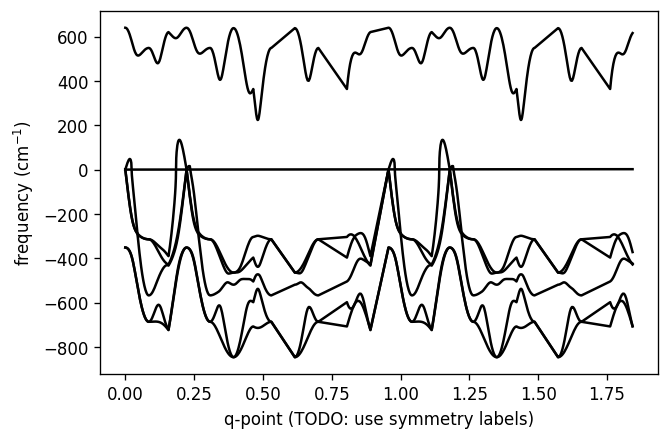

In [75]:
# run plotting script
# read in the file
import matplotlib.pyplot as plt
n = 120
plt.rcParams['figure.dpi'] = n
plt.rcParams['savefig.dpi'] = n
freq = open(f"{vcomp.reduced_formula}.freq.gp","r")
lines = freq.readlines()
q = []
for line in lines:
    data = np.array(line.split()).astype(float)
    q.append(data)
freq.close()
q = np.asmatrix(q)
n = -1
for i in range(q.shape[1]):
    plt.plot(q[0:n,0],q[0:n,i],color='black')
plt.xlabel("q-point (TODO: use symmetry labels)")
plt.ylabel("frequency (cm$^{-1}$)")
plt.savefig('dispersion.png')
plt.show()
for i in range(q.shape[1]):
    plt.plot(q[0:n,0],q[0:n,i],color='black')
plt.xlabel("q-point (TODO: use symmetry labels)")
plt.ylabel("frequency (cm$^{-1}$)")
plt.savefig('dispersion.png')
plt.show()

In [94]:
from pymatgen.phonon.bandstructure import PhononBandStructureSymmLine
from pymatgen.phonon.plotter import PhononBSPlotter

(602, 3) (6, 602)


<module 'matplotlib.pyplot' from '/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/matplotlib/pyplot.py'>

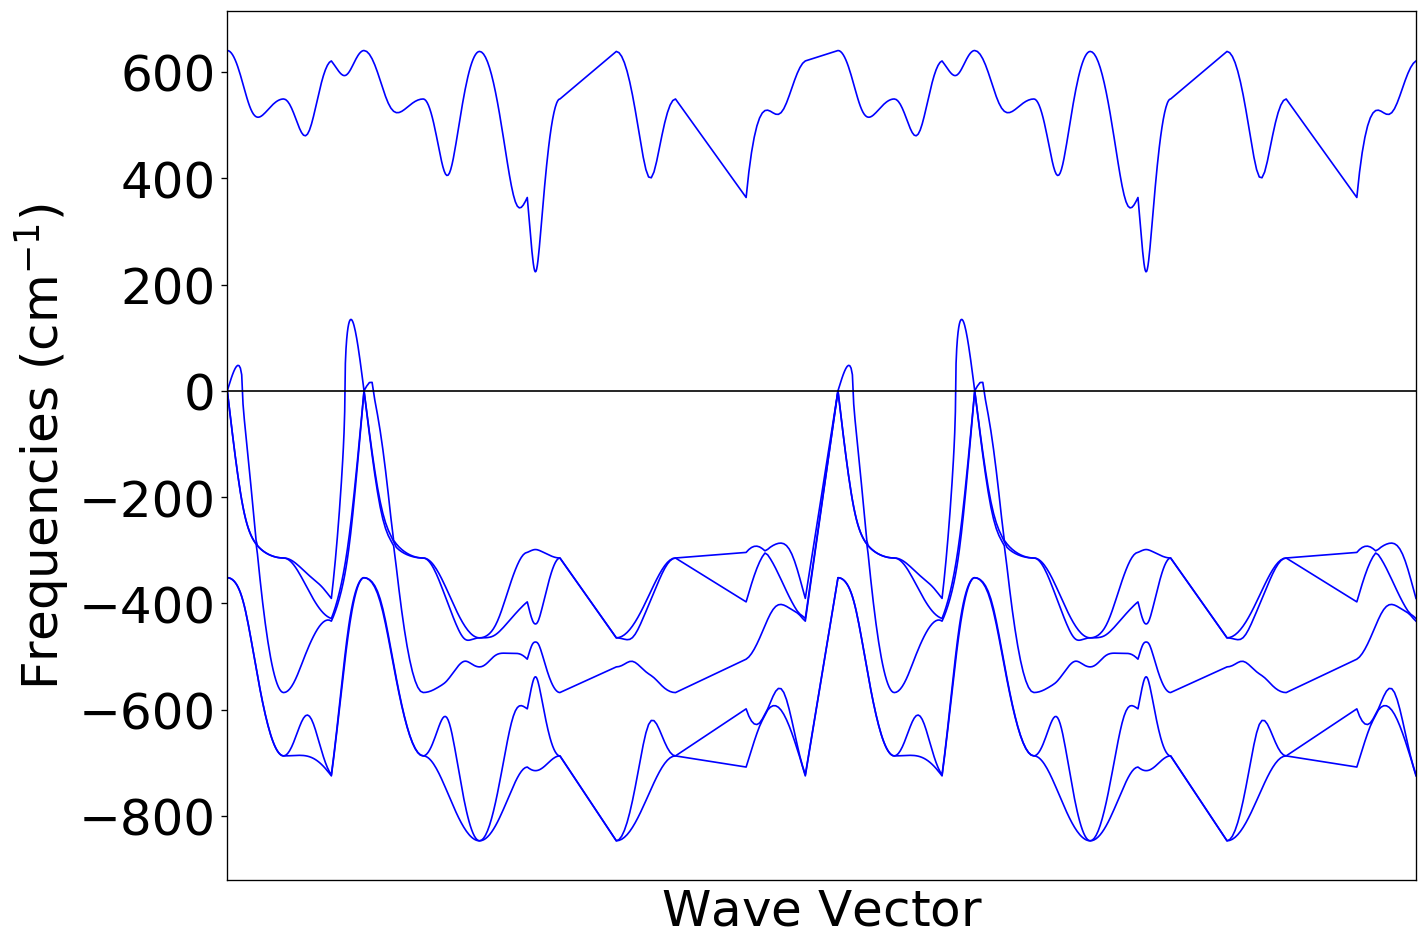

In [160]:
freq = open(f"{vcomp.reduced_formula}.freq","r")
lines = freq.readlines()
qpoints = np.array([line.split() for line in lines[1::2]]).astype(float)
frequencies = np.array([line.split() for line in lines[2::2]]).astype(float)
freq.close()
# qpoints = np.transpose(qpoints)
frequencies = np.transpose(frequencies) / 33.356  # * .004136 # / 33.356 # convert from cm^-1 to eV
print(qpoints.shape,frequencies.shape)
bands = PhononBandStructureSymmLine(qpoints = qpoints, frequencies = frequencies, lattice = struct.lattice.reciprocal_lattice)
plotter = PhononBSPlotter(bands)
plotter.get_plot(units = 'cm^-1')

In [126]:
frequencies[5,0]

640.3717

In [152]:
plotter.bs_plot_data()

{'ticks': {'distance': [], 'label': []},
 'distances': [[0.0,
   0.004405596389757059,
   0.008810004292634427,
   0.013215600682391485,
   0.017621942892215345,
   0.022027539281972403,
   0.02643194718484977,
   0.030837543574606833,
   0.0352419514774842,
   0.03964754786724126,
   0.04405507835044122,
   0.04845948625331859,
   0.05286508264307565,
   0.05726949054595302,
   0.061675086935710076,
   0.06607949483858745,
   0.07048509122834451,
   0.07489143343816837,
   0.07929702982792543,
   0.08370143773080278,
   0.08810703412055984,
   0.09251263051031691,
   0.09691703841319428,
   0.10132263480295134,
   0.10572897701277519,
   0.11013457340253226,
   0.11453898130540961,
   0.11894457769516668,
   0.12334898559804405,
   0.1277545819878011,
   0.13216211247100107,
   0.13656652037387845,
   0.14097211676363552,
   0.14537652466651288,
   0.14978212105626992,
   0.1541865289591473,
   0.15859212534890438,
   0.1629984675587282,
   0.16740406394848528,
   0.17180847185136264,